In [1]:
import scipy
import numpy as np
from matplotlib import cm, colors, rc, patches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from control import dare
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.utils.optical_input import *
from single_photons.utils.metrics import *
from single_photons.environment import Cavity_Particle
from single_photons.simulation.simulation_cavity import simulation_c

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['figure.dpi'] = 200 #600 for figure generation
C = ['#2E86C1', '#85C1E9', '#1B4F72']

In [3]:
def post_process_snr(snr):
    if not np.equal(snr, None).sum():
        mean_pos = np.mean(snr)
        std_pos = np.std(snr)
    else:
        mean_pos = 0
        std_pos = 0
    return mean_pos, std_pos

In [4]:
delta_t = 4e-9
rho = 1850
index_refraction = 1.4440
T = 293
p = 9.2e-7
radius = 71.5e-9
wavelength = 1.064e-6
power = 300e-3
eta_detection = 0.34 #0.178 = info
control_step = int(32e-9/delta_t) 
fs = 1/(control_step*delta_t)
tweezer_waist = 3.7352e-6#np.sqrt(0.67*0.77)*1e-6 
g_fb_ratio = 1
laser_linewidth = 0
omega = 2*np.pi*104e3
period = 2*np.pi/omega

t = np.arange(0, 300*period, delta_t)
N = t.shape[0]
zp_x = compute_zpx(omega, radius, rho = rho)

In [5]:
cavity_length = 0.03
updated_length = compute_resonance_length(cavity_length, wavelength)
cavity_linewidth = 1e6
detuning_ratio = 0.3
gamma, ba_force, std_detection, std_z, g_cs, detuning =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection, 
                                     updated_length, detuning_ratio, cavity_linewidth, omega,
                                     T = T, rho = rho, index_refraction = index_refraction)
std_detection = std_detection/zp_x
coupling = (1/(4*np.pi))*(ba_force**2)

In [6]:
env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    g_cs,
    coupling,
    radius=radius,
    eta_detection=eta_detection,
    T=T,
    g_fb_ratio = g_fb_ratio
)

In [7]:
variance_process = env.thermal_force_std**2 + env.backaction_std**2
Q = control_step*delta_t/2*np.array(
    [
        [env.__shot_std__**2, 0, 0, 0],
        [0, env.__shot_std__**2, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process]
    ])
R = np.array([[np.power(std_detection, 2)]])
Ad = scipy.linalg.expm(env.A * control_step * delta_t)
Bd = env.B * delta_t * control_step
#cov_ss = dare(Ad.T, Bd, Q, R)[0]
cov_ss = dare(Ad, Bd, Q, R)[0] #gives better SNR for fidelity than above. why?

In [8]:
sim_sample_bool = 1
phonon_bool = 1
SNR_bool = 1
SNR_colormap_acquire = 1
SNR_colormap_plot = 1
detection_measures_bool = 0

x0 = 0
P0 = std_detection**2*np.eye(4)
photon_number = 5#2000
duration = 50e-6#period/10
step = int(period/(delta_t*control_step))

FSR, f, r, I_factor, optical_input = compute_optical_input(N, delta_t, env, laser_linewidth, photon_number, updated_length, wavelength, duration)

In [9]:
if sim_sample_bool or phonon_bool:
    new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
        env.A,
        env.B, 
        optical_input,
        env.thermal_force_std,
        env.backaction_std,
        env.__shot_std__,
        std_detection, 
        eta_detection,
        x0, 
        P0, 
        Ad, 
        Bd, 
        env.C, 
        env.G,
        env.G_lqr,
        Q, 
        R, 
        delta_t, 
        control_step, 
        N
    )

C:\Users\calif\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\calif\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\calif\AppData\Local\Temp\ipykernel_6304\2846259847.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  signal[i] = zp_x/1e-9*(measured_states[::control_step][i] - estimated_states[::control_step,2][i]).real


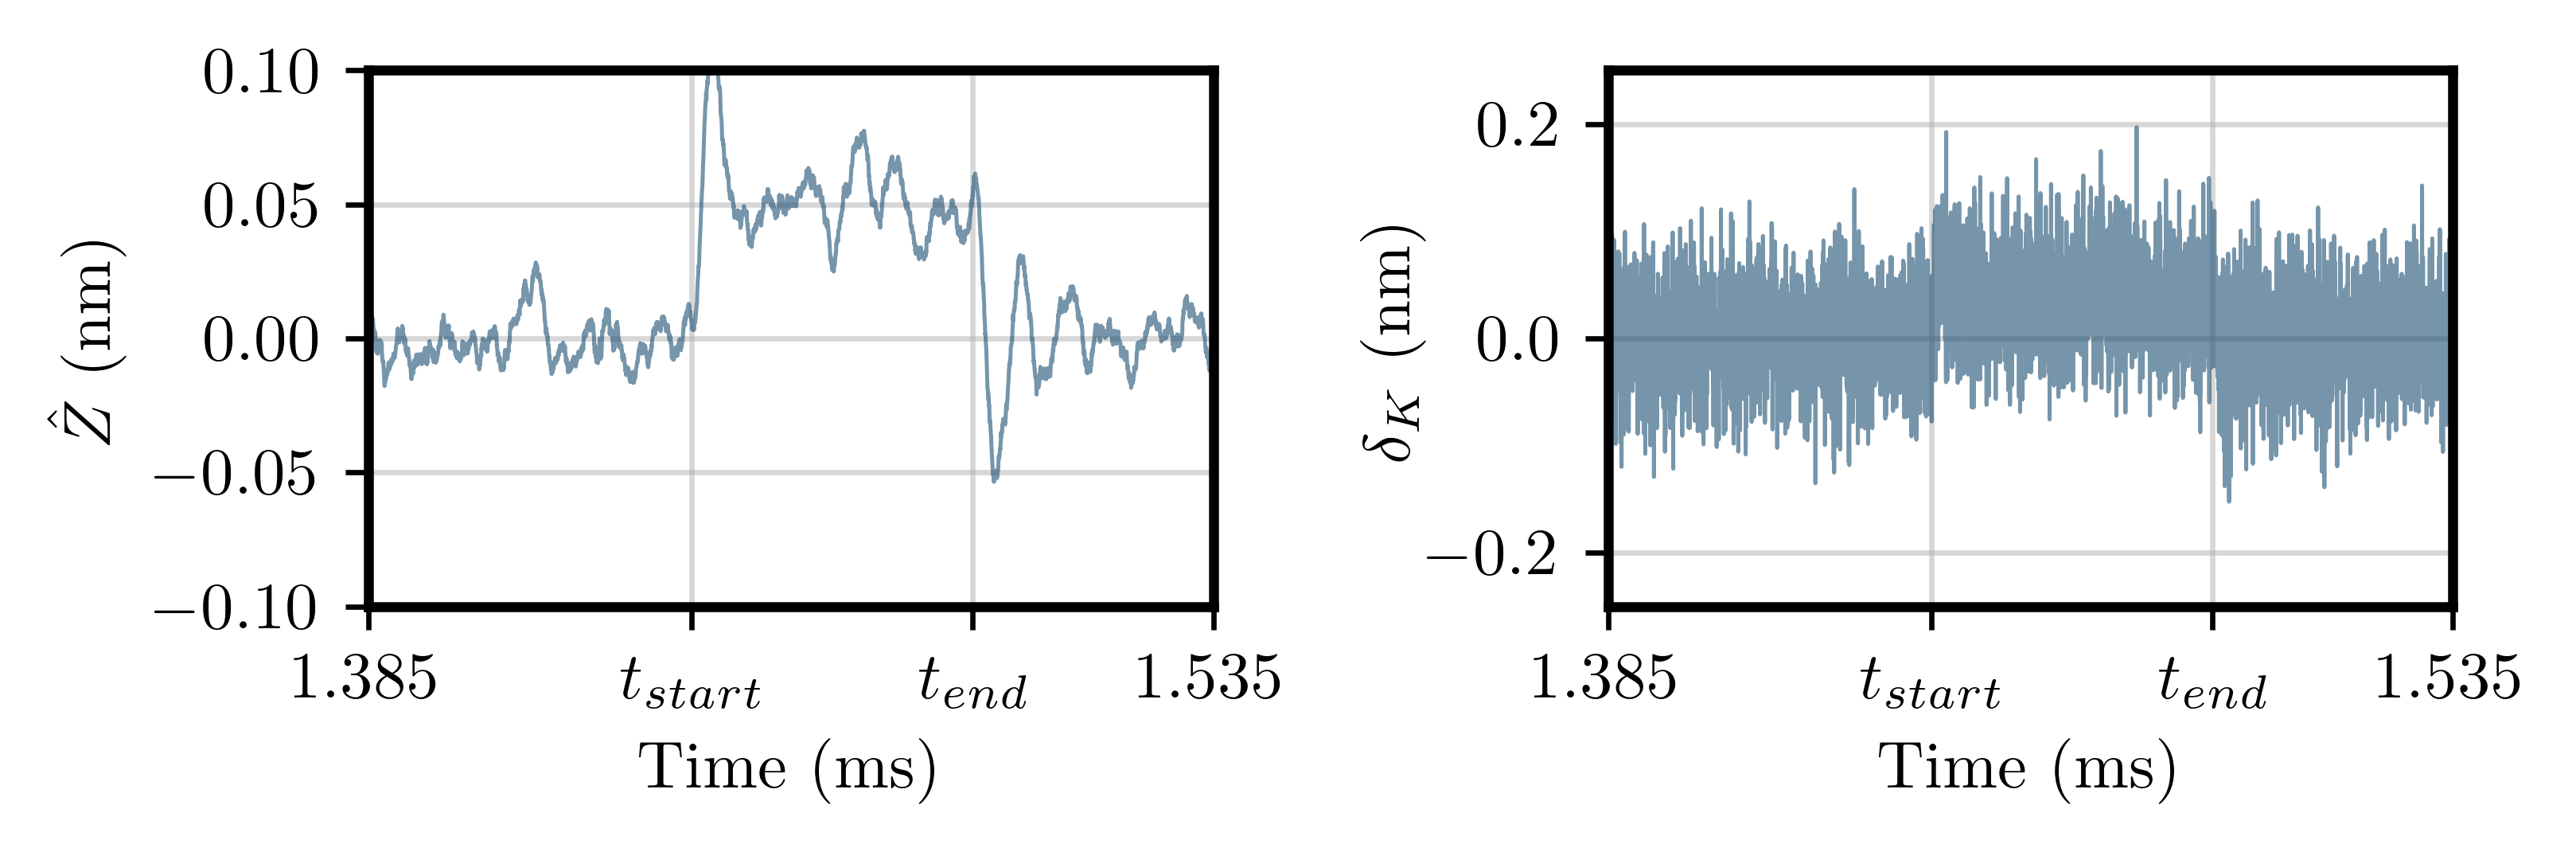

In [64]:
if sim_sample_bool:
    '''List of parameters used in last run:
    delta_t = 4e-9
    rho = 2200
    index_refraction = 1.4440
    T = 293
    p = 9.2e-7
    radius = 71.5e-9
    wavelength = 1.064e-6
    power = 300e-3
    eta_detection = 0.34 #0.178 = info
    control_step = int(32e-9/delta_t) 
    fs = 1/(control_step*delta_t)
    tweezer_waist = 3.7352e-6#np.sqrt(0.67*0.77)*1e-6 
    g_fb_ratio = 1
    laser_linewidth = 0
    omega = 2*np.pi*104e3
    period = 2*np.pi/omega
    cavity_length = 0.03
    cavity_linewidth = 1e6
    detuning_ratio = 0.3
    photon_number = 5
    duration = 50e-6'''

    duration = 50e-6
    factor = 1.57
    fig, ax = plt.subplots(1, 2, figsize = (3.5*factor,1.2*factor))
    plt.rcParams.update({'font.size': 10})
    plt.rcParams['axes.linewidth'] = 1.5
    
    left = int((N/2 - 2*duration/delta_t)/control_step)
    right = int((N/2 + 3*duration/delta_t)/control_step)
    
    ax[0].plot(1e3*t[::control_step][left:right],
             estimated_states[:,2][::control_step][left:right]*zp_x/1e-9,
             color = C[2], alpha = 0.6, linewidth = 0.6)
    ax[0].set_xlim([1.385,1.535])
    ax[0].set_xticks(np.array([1.385, 1e3*(N/2*delta_t), 1e3*(N/2*delta_t + duration), 1.535]),
                 labels = ['1.385', r'$t_{start}$', '$t_{end}$', '1.535'])
    ax[0].grid(alpha = 0.5)
    ax[0].set_ylim([-0.10, 0.10])
    ax[0].set_ylabel(r'$\hat{Z}$ (nm)')
    ax[0].set_xlabel(r'Time (ms)')
    
    size = int(N/control_step)
    signal = np.zeros(size)
    x = t[::control_step][:size]
    for i in range(size):
        signal[i] = zp_x/1e-9*(measured_states[::control_step][i] - estimated_states[::control_step,2][i]).real
    
    ax[1].plot(1e3*x, signal, color = C[2], alpha = 0.6, linewidth = 0.6)
    ax[1].set_xlabel(r'Time (ms)')
    ax[1].set_ylabel(r'$\delta_K$ (nm)', labelpad = 0)
    ax[1].set_xlim([1.385,1.535])
    ax[1].set_xticks(np.array([1.385, 1e3*(N/2*delta_t), 1e3*(N/2*delta_t + duration), 1.535]),
               labels = ['1.385', r'$t_{start}$', '$t_{end}$', '1.535'])
    ax[1].set_ylim([-0.25, 0.25])
    ax[1].grid(alpha = 0.5)
    
    plt.rcParams['figure.dpi'] = 600
    plt.tight_layout()
    #plt.savefig('simulation_sample_cav.pdf', bbox_inches = 'tight')

25.81219069096988 13.933029626676795 0.001442308 0.0014423076923076922


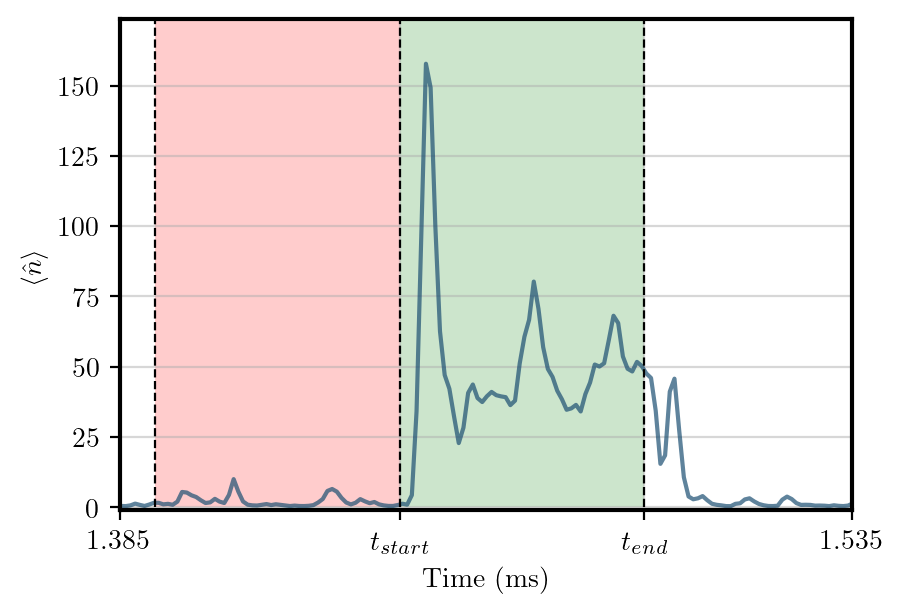

In [14]:
if phonon_bool == 1:
    factor = 1.32
    fig = plt.figure()
    plt.grid(alpha = 0.5)
    fig.set_size_inches(3.5*factor, 2.4*factor, forward = True)
    plt.rcParams.update({'font.size': 10})
    plt.rcParams['axes.linewidth'] = 1.5
    t_start = t[int(N/2)]
    t_left = 1.385e-3
    t_right = 1.535e-3
    left = int(t_left/(delta_t*control_step*step))
    right = int(t_right/(delta_t*control_step*step))
    step=int(0.1*period/(delta_t*control_step))
    phn = compute_phonons(estimated_states, cov_aposteriori, control_step, step = step, cavity_bool = 1)
    M_phn = max(phn[left:right])
    plt.plot(1e3*t[::control_step][::step][2:], phn,
             color = C[2], alpha = 0.7)
    plt.xlim([1e3*t_left, 1e3*t_right])
    plt.plot(2*[1e3*t[int(N/2)]],[0,1.1*M_phn], color = 'black', linewidth = 0.8, linestyle = 'dashed')
    plt.plot(2*[1e3*(duration + t_start)],[0,1.1*M_phn], color = 'black', linewidth = 0.8, linestyle = 'dashed')
    plt.plot(2*[1e3*(- duration + t_start)],[0,1.1*M_phn], color = 'black', linewidth = 0.8, linestyle = 'dashed')
    rect1 = patches.Rectangle((1e3*(t_start - duration),0), 1e3*duration, 1.1*max(phn[left:right]),
                              linewidth = 1, facecolor = 'r', fill = 1, alpha = 0.2)
    rect2 = patches.Rectangle((1e3*t_start,0), 1e3*duration, 1.1*M_phn,
                              linewidth = 1, facecolor = 'g', fill = 1, alpha = 0.2)
    plt.gca().add_patch(rect1)
    plt.gca().add_patch(rect2)
    plt.xlabel(r'Time (ms)')
    plt.ylabel(r'$\langle \hat{n} \rangle$')
    plt.xticks(np.array([1.385, 1e3*(N/2*delta_t), 1e3*(N/2*delta_t + duration), 1.535]),
               labels = ['1.385', r'$t_{start}$', '$t_{end}$', '1.535'])
    plt.ylim([-1, 1.1*max(phn[left:right])])
    plt.tight_layout()

    start_pos = int(N/2/control_step)
    end_pos = start_pos + int(duration/(control_step*delta_t))
    start_phn = int(N/2/(control_step*step))
    end_phn = start_phn + int(duration/(step*control_step*delta_t))
    SNR_pos = compute_SNR(estimated_states[::control_step,2].real, start_pos, end_pos)
    SNR_phn = compute_SNR(phn, start_phn, end_phn)
    print(SNR_phn, SNR_pos, t[int(N/2)], 150*period)
    plt.savefig('pulse_phonons.pdf', dpi = 600)

In [35]:
if detection_measures_bool:
    data = []
    numbers = np.array([0.5, 9, 80])
    
    for photon_number in tqdm(numbers):
        if 'optical_input' in globals():
            del optical_input
        if 'new_states' in globals():
            del new_states, measured_states, estimated_states, cov_aposteriori, controls
        FSR, f, r, I_factor, optical_input = compute_optical_input(
            N, delta_t, env, laser_linewidth, photon_number, updated_length, wavelength, duration)
        new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
            env.A,
            env.B, 
            optical_input,
            env.thermal_force_std,
            env.backaction_std,
            env.__shot_std__,
            std_detection, 
            eta_detection,
            x0, 
            P0, 
            Ad, 
            Bd, 
            env.C, 
            env.G,
            env.G_lqr,
            Q, 
            R, 
            delta_t, 
            control_step, 
            N
        )
        
        X = estimated_states[:,0][::control_step].real
        Y = estimated_states[:,1][::control_step].real
        pos = estimated_states[:,2][::control_step].real
        P = estimated_states[:,3][::control_step].real
        phonons = compute_phonons(estimated_states, cov_aposteriori, control_step, step = step)
        fidelity = compute_fidelity(estimated_states, cov_aposteriori, cov_ss, control_step, step=step)
        
        data.append([X, Y, pos, P, phonons, fidelity])
        del X, Y, pos, P, phonons, fidelity
    data = np.array(data)

In [36]:
if detection_measures_bool:
    '''List of parameters used in last run:
    delta_t = 5e-9
    rho = 2200
    index_refraction = 1.4440
    T = 293
    p = 9.2e-7
    radius = 71.5e-9
    wavelength = 1.064e-6
    power = 300e-3
    eta_detection = 0.3
    control_step = int(32e-9/delta_t) 
    fs = 1/(control_step*delta_t)
    tweezer_waist = 3.7352e-6
    g_fb_ratio = 50
    laser_linewidth = 0
    omega = 2*np.pi*104e3
    t = np.arange(0, 3000*period, delta_t)
    cavity_length = 0.03/1.001
    cavity_linewidth = 10*omega
    detuning_ratio = 1
    photon_number = 25
    duration = 5e-5
    step = 40
    start = int(25e-6/(delta_t*control_step*step))
    numbers = np.array([0.5, 9, 80])
    '''
    factor = 0.76
    nrow = 3
    ncol = 4
    fig, ax =\
        plt.subplots(nrow, ncol, figsize = (factor*9,factor*5))
    plt.rcParams.update({'font.size':9})
    plt.rcParams['axes.linewidth'] = 0.1
    plt.tight_layout()

    inf_xlim = 14.35#1e3*N/2*delta_t - 2e3*duration
    sup_xlim = 14.55#1e3*N/2*delta_t + 3e3*duration
    
    n_colors = ['gray', C[2], C[1]]
    for i in range(nrow):
        alpha = 0.6 + i/10
        color = n_colors[i]
        for j in range(ncol):
            if j < 2:
                lw = 0.5
            else:
                lw = 1.0
                
            if j < 2:
                ax[i,j].plot(1e3*t[::control_step], data[i, 2*j], alpha = alpha, color = color, linewidth = lw, linestyle = 'solid')
                ax[i,j].plot(1e3*t[::control_step], data[i, 2*j+1], alpha = alpha, color = color, linewidth = lw, linestyle = 'dashed')
            elif j == 2:
                ax[i,j].plot(1e3*t[::control_step*step][:data[i, j+2].shape[0]],
                             data[i, j+2], alpha = alpha, color = color, linewidth = lw)
            else:
                ax[i,j].plot(1e3*t[::control_step*step][:data[i, j+2].shape[0]],
                             1-data[i, j+2]/max(data[i, j+2][30:]), alpha = alpha, color = color, linewidth = lw)
            ax[i,j].set_xlim([inf_xlim, sup_xlim])
            if j == 0:
                ax[0,j].set_ylim([-0.1, 0.1])
                ax[0,j].set_yticks(np.arange(-0.1,0.11,step = 0.1))
                ax[1,j].set_ylim([-0.3, 0.3])
                ax[1,j].set_yticks(np.arange(-0.3,0.31,step = 0.3))
                ax[2,j].set_ylim([-1,1])
                ax[2,j].set_yticks(np.arange(-1,1.1))
            if j == 1:
                ax[0,j].set_ylim([-3,3])
                ax[1,j].set_ylim([-6,6])
                ax[2,j].set_ylim([-16,16])
            if j == 2:
                ax[i,j].set_ylim([0,2 - 21*i + 32*i**2])
            if j == 3:
                ax[i,j].set_ylim([-0.1,1])
            ax[i,j].set_xticks(np.array([14.35, 1e3*(N/2*delta_t), 1e3*(N/2*delta_t + duration), 14.55]),
                               labels = ['14.35', r'$t_{s}$', '$t_{e}$', '14.55'])
            ax[i,j].grid(alpha=0.4)
            if i == 2:
                ax[i,j].set_xlabel(r'$t$ (ms)', fontsize = plt.rcParams['font.size'])
                '''ax[i,j].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))'''
    ax[0,0].set_title(r'$\langle \hat{X} \rangle, \langle \hat{Y} \rangle$', fontsize = plt.rcParams['font.size'])
    ax[0,1].set_title(r'$\langle \hat{Z}/Z_{zpm} \rangle, \langle \hat{P}/P_{zpm} \rangle$', fontsize = plt.rcParams['font.size'])
    ax[0,2].set_title(r'$\hat{n}_{quanta}$', fontsize = plt.rcParams['font.size'])
    ax[0,3].set_title(r'$1-\mathcal{F} \left[ \hat{\rho}, \rho_{ss} \right]$', fontsize = plt.rcParams['font.size'])
    ax[0,0].set_ylabel(r'$\langle n_\gamma \rangle$ =' + ' {}'.format(numbers[0]), labelpad = 0, fontsize = plt.rcParams['font.size'])
    ax[1,0].set_ylabel(r'$\langle n_\gamma \rangle$ =' + ' {}'.format(numbers[1]), labelpad = 0, fontsize = plt.rcParams['font.size'])
    ax[2,0].set_ylabel(r'$\langle n_\gamma \rangle$ =' + ' {}'.format(numbers[2]), labelpad = 7, fontsize = plt.rcParams['font.size'])
    ax[2,2].set_yticks(np.arange(0,81,step=40))
        
    #plt.savefig('detection_measures.pdf', bbox_inches = 'tight')
    #plt.show()

In [21]:
if SNR_bool:
    data = []
    numbers = np.power(np.linspace(1,10,28),2)
    left = int(N/2 - duration/delta_t)
    right = int(N/2 + duration/delta_t)
    step = int(1*period/(delta_t*control_step))

    for photon_number in tqdm(numbers):
        if 'optical_input' in globals():
            del optical_input
        if 'new_states' in globals():
            del new_states, measured_states, estimated_states, cov_aposteriori, controls
        FSR, f, r, I_factor, optical_input = compute_optical_input(
            N, delta_t, env, laser_linewidth, photon_number, updated_length, wavelength, duration)
        new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
            env.A,
            env.B, 
            optical_input,
            env.thermal_force_std,
            env.backaction_std,
            env.__shot_std__,
            std_detection, 
            eta_detection,
            x0, 
            P0, 
            Ad, 
            Bd, 
            env.C, 
            env.G,
            env.G_lqr,
            Q, 
            R, 
            delta_t, 
            control_step, 
            N
        )
        
        phonons = compute_phonons(estimated_states, cov_aposteriori, control_step, step = step)
        #fidelity = 1 - compute_fidelity(estimated_states, cov_aposteriori, cov_ss, control_step, step=step)

        start_pos = int(N/2/control_step)
        end_pos = start_pos + int(duration/(control_step*delta_t))
        start_phn = int(N/2/(control_step*step))
        end_phn = start_phn + int(duration/(step*control_step*delta_t))
        
        SNR_pos = compute_SNR(estimated_states[::control_step,2].real, start_pos, end_pos)
        SNR_phn = compute_SNR(phonons, start_phn, end_phn)
        #SNR_fid = compute_SNR(fidelity,int(left/(step*control_step)),int(right/(step*control_step)))
        
        data.append([SNR_pos, SNR_phn])#, SNR_fid])
    data = np.array(data)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:51<00:00,  1.85s/it]


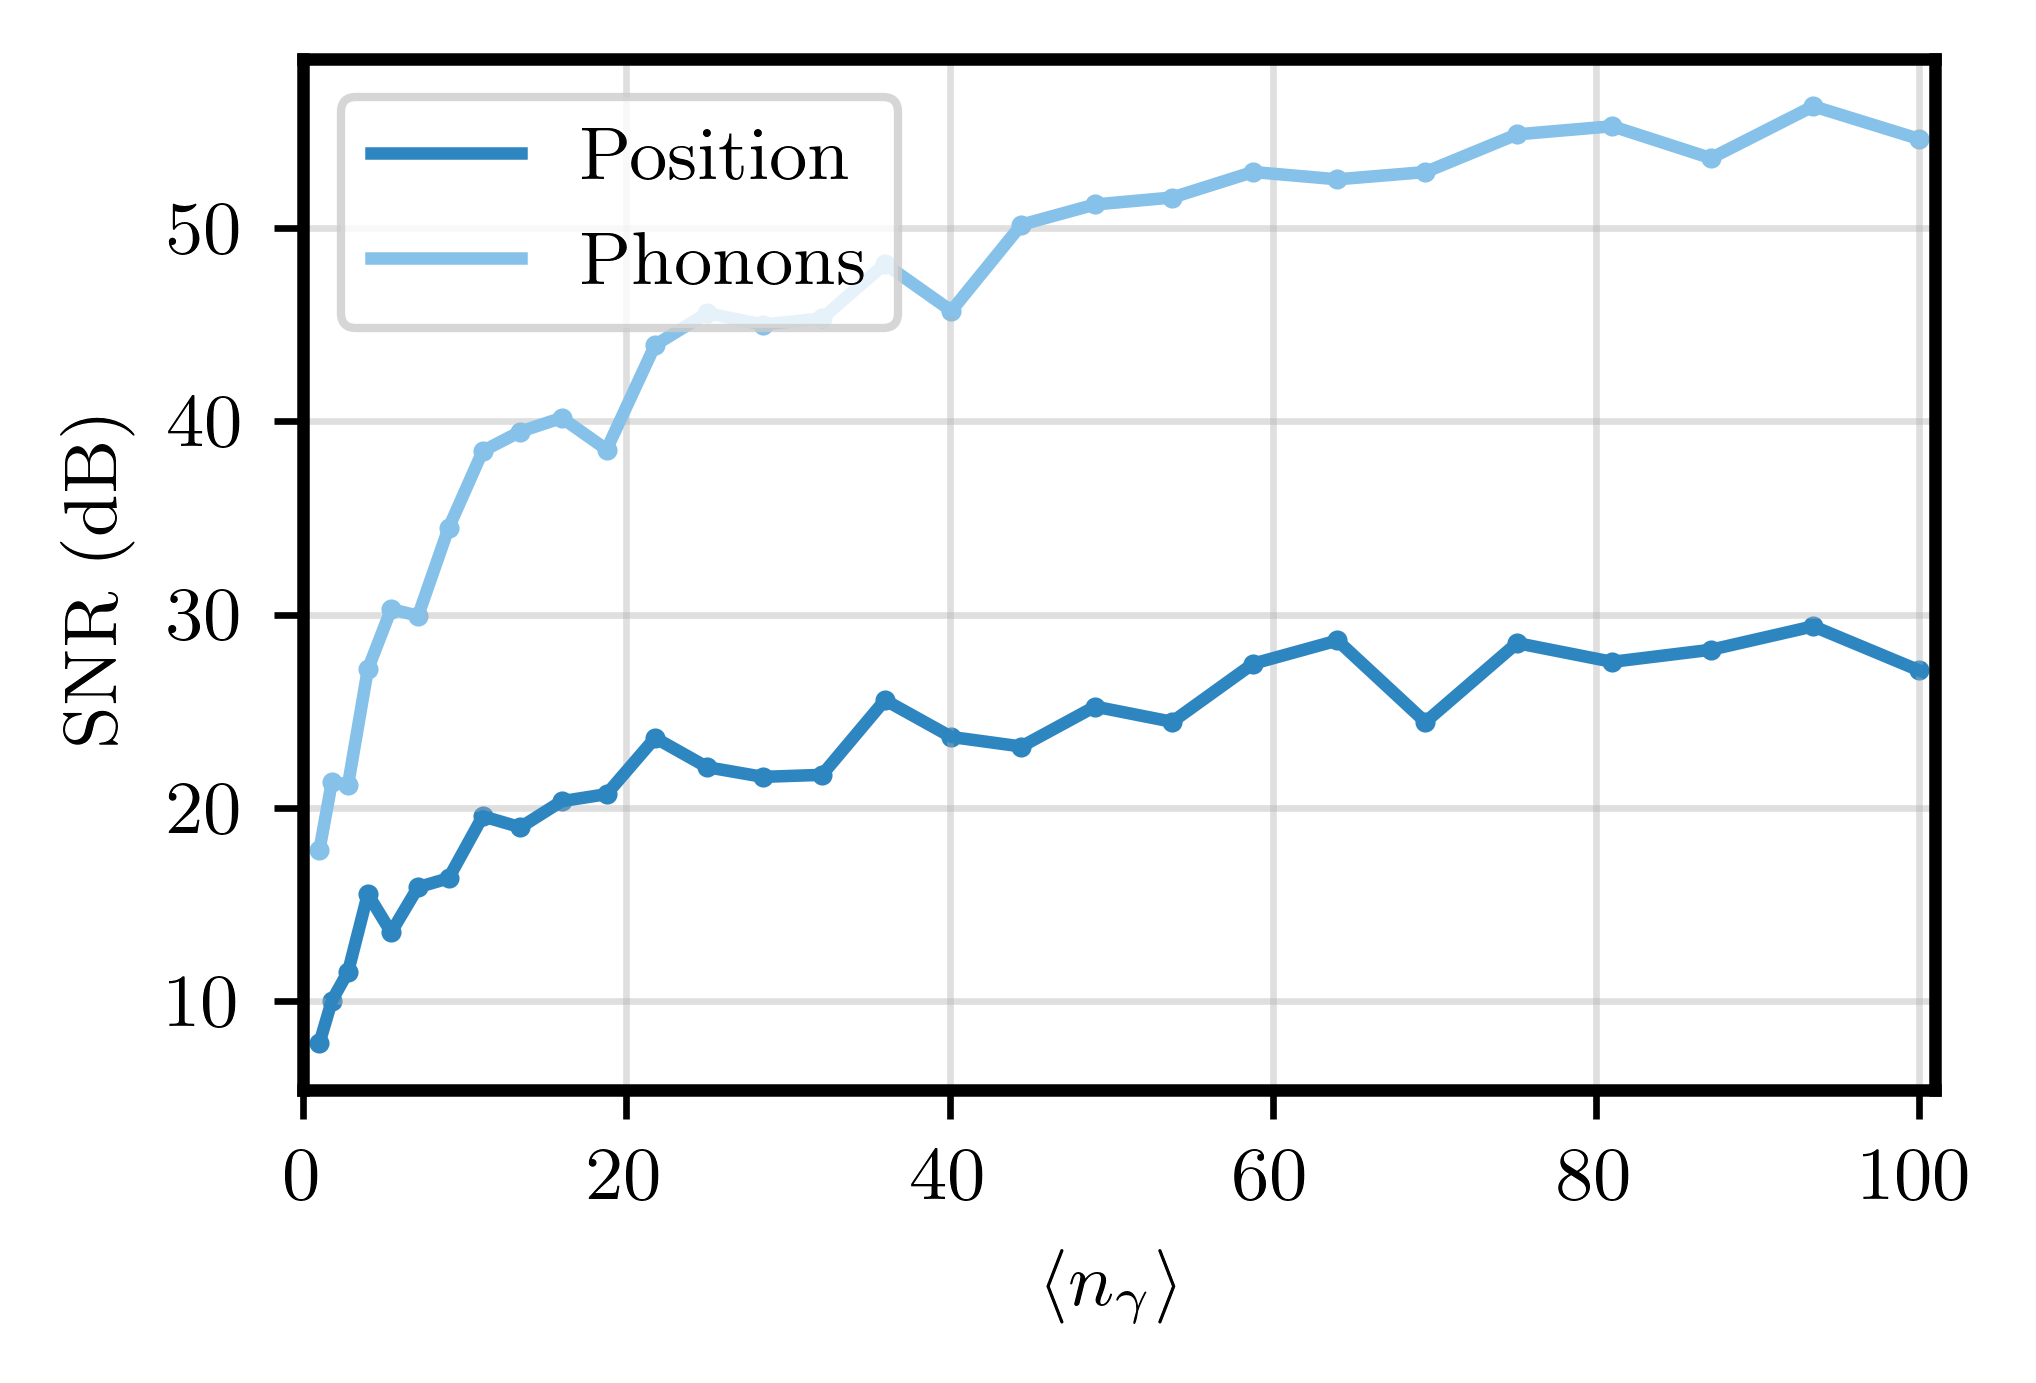

In [23]:
if SNR_bool:
    '''Parameters used in the last run:
    delta_t = 4e-9
    rho = 1850
    index_refraction = 1.4440
    T = 293
    p = 9.2e-7
    radius = 71.5e-9
    wavelength = 1.064e-6
    power = 300e-3
    eta_detection = 0.34
    control_step = int(30e-9/delta_t) 
    fs = 1/(control_step*delta_t)
    cavity_length = 0.03
    tweezer_waist = 3.7352e-6
    detuning_ratio = 0.3
    cavity_linewidth = 1e6
    laser_linewidth = 0
    numbers = np.power(np.linspace(1,10,28),2)
    step = int(0.1*period/(delta_t*control_step))
    '''
    labels = ['Position', 'Phonons', 'Fidelity']
    factor = 0.99
    fig,ax = plt.subplots()
    plt.rcParams.update({'font.size':9})
    plt.rcParams['axes.linewidth'] = 1.5
    fig.set_size_inches(3.5*factor, 2.4*factor, forward = True)
    plt.grid(alpha = 0.4)
    
    M = 0
    for i in range(2):
        y = np.array(data.shape[0]*[None])
        x = np.array(data.shape[0]*[None])
        for j in range(data.shape[0]):
            non_null_y = []
            if np.isnan(data[j,i]):
                continue
            else:
                x[j] = numbers[j]
                y[j] = data[j,i]
                non_null_y.append(data[j,i])
            if max(non_null_y) > M:
                M = max(non_null_y)
        ax.plot(x, y, color = C[i], label = labels[i])
        ax.scatter(x, y, color = C[i], s = 2)
    ymin = -0.1*M
    ymax = 1.1*M
    xmin = 0
    xmax = numbers[-1] + numbers[0]
    ax.set_xlim([xmin, xmax])
    #ax.fill_between(np.array([xmin, xmax]), np.array(2*[ymin]), np.array(2*[20]), color = 'gray', alpha = 0.3)
    plt.ylabel(r'SNR (dB)', fontsize = plt.rcParams['font.size'])
    plt.xlabel(r'$\langle n_\gamma \rangle$', fontsize = plt.rcParams['font.size'])
    plt.legend(loc = 'upper left', fontsize = plt.rcParams['font.size'])
    plt.tight_layout()
    #plt.savefig('SNR_measures.pdf',bbox_inches = 'tight',dpi = 600)

In [22]:
if SNR_colormap_acquire:
    linewidths = omega*np.linspace(0.1,5,50)
    detunings = np.linspace(-0.26,0.26,27)
    N_runs = 10
    SNR_data = np.zeros((linewidths.shape[0],detunings.shape[0]))

    start_phn = int(N/2/(control_step*step))
    end_phn = start_phn + int(duration/(step*control_step*delta_t))

    t = np.arange(0, 300*period, delta_t)
    N = t.shape[0]
    step = int(period/(delta_t*control_step))
    
    for i in tqdm(range(linewidths.shape[0])):
        for j in tqdm(range(detunings.shape[0])):
            SNR_part = np.zeros(N_runs)
                
            detuning_ratio = detunings[j]
            cavity_linewidth = linewidths[i]
            
            gamma, ba_force, std_detection, std_z, g_cs, detuning =\
            compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection, 
                                                 updated_length, detuning_ratio, cavity_linewidth, omega,
                                                 T = T, rho = rho, index_refraction = index_refraction)
            std_detection = std_detection/zp_x
            coupling = (1/(4*np.pi))*(ba_force**2)
            env = Cavity_Particle(
            omega,
            gamma,
            detuning,
            cavity_linewidth,
            g_cs,
            coupling,
            radius=radius,
            eta_detection=eta_detection,
            T=T,
            g_fb_ratio = g_fb_ratio
            )

            variance_process = env.thermal_force_std**2 + env.backaction_std**2
            Q = control_step*delta_t/2*np.array(
                [
                    [env.__shot_std__**2, 0, 0, 0],
                    [0, env.__shot_std__**2, 0, 0],
                    [0, 0, 0, 0],
                    [0, 0, 0, variance_process]
                ])
            R = np.array([[np.power(std_detection, 2)]])
            Ad = scipy.linalg.expm(env.A * control_step * delta_t)
            Bd = env.B * delta_t * control_step
            #cov_ss = dare(Ad.T, Bd, Q, R)[0]
            cov_ss = dare(Ad, Bd, Q, R)[0] #gives better SNR for fidelity than above. why?

            FSR, f, r, I_factor, optical_input = compute_optical_input(N, delta_t, env, laser_linewidth, photon_number, updated_length, wavelength, duration)
            for run in range(N_runs):
                if 'phonons' in globals():
                    del phonons
                new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
                    env.A,
                    env.B, 
                    optical_input,
                    env.thermal_force_std,
                    env.backaction_std,
                    env.__shot_std__,
                    std_detection, 
                    eta_detection,
                    x0, 
                    P0, 
                    Ad, 
                    Bd, 
                    env.C, 
                    env.G,
                    env.G_lqr,
                    Q, 
                    R, 
                    delta_t, 
                    control_step, 
                    N
                )
                phonons = compute_phonons(estimated_states, cov_aposteriori, control_step, step = step, cavity_bool = 1)
                SNR_part[run] = compute_SNR(phonons, start_phn, end_phn)
            
            SNR_data[i,j] = np.mean(SNR_part)
    np.savetxt('SNR_data.txt',SNR_data)

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [6:22:32<00:00, 459.06s/it]


[[ 2.33475978  2.85123349  3.50287956 ...  0.24955349  0.27950387
   0.11849551]
 [ 3.69482365  4.61793167  5.10228361 ...  0.45577056  0.41839237
   0.27470473]
 [ 5.11559043  6.30851503  6.71736954 ...  0.95840443  0.9641728
   0.70048289]
 ...
 [44.14392883 45.58478618 44.36823506 ... 45.23950837 44.4459449
  44.41517653]
 [45.02938157 45.37112791 45.99340746 ... 46.37143905 45.36679292
  43.61378789]
 [45.03520596 45.58265902 46.77880564 ... 44.85843591 45.75752047
  43.7557669 ]]


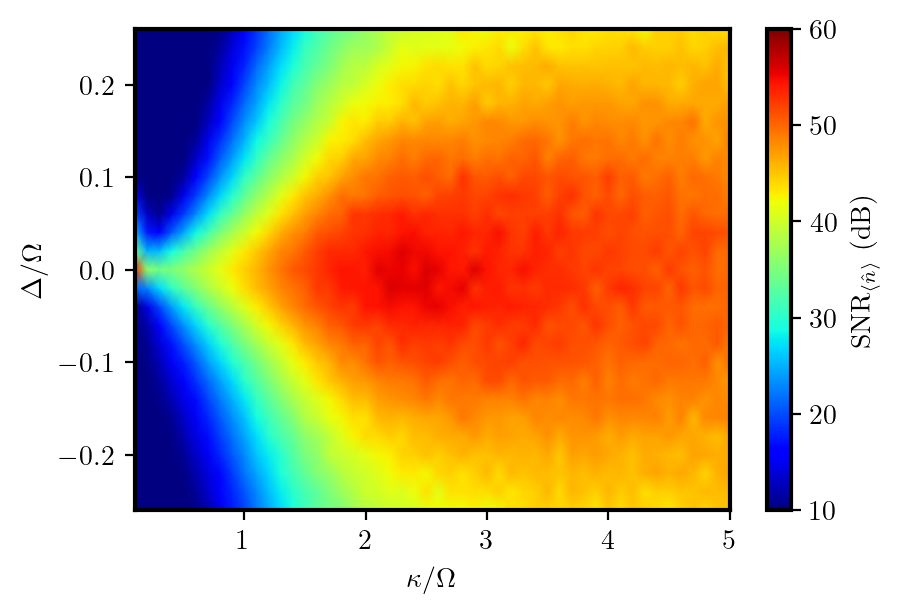

In [39]:
if SNR_colormap_plot:
    print(SNR_data)
    if not SNR_colormap_acquire:
        linewidths = omega*np.linspace(0.1,5,50)
        detunings = np.linspace(-0.25,0.25,26)
        SNR_data = np.loadtxt('SNR_data.txt')
    
    factor = 1.32
    fig = plt.figure()
    plt.rcParams.update({'font.size': 10})
    plt.rcParams['axes.linewidth'] = 1.5
    fig.set_size_inches(3.5*factor, 2.4*factor, forward = True)
    
    plt.pcolormesh(linewidths/omega,detunings,SNR_data.T, cmap = 'jet', vmin=10, vmax=60, shading = 'gouraud')
    plt.colorbar(label = r'$\textrm{SNR}_{\langle \hat{n} \rangle}$ (dB)')
    plt.xlabel(r'$\kappa/\Omega$')
    plt.ylabel(r'$\Delta/\Omega$')
    plt.tight_layout()
    #plt.savefig('SNR_colormap.pdf', dpi = 600)

In [11]:
left = N/2 - duration/delta_t
right = N/2 + duration/delta_t
sample = estimated_states[int(left):int(right),:].real
cov_sample = cov_aposteriori[int(left/control_step):int(right/control_step),:,:]

cov_ss_1 = dare(Ad.T, Bd, Q, R)[0]
cov_ss_2 = dare(Ad,Bd,Q,R)[0]
fidelity_1 = compute_fidelity(sample,cov_sample, cov_ss_1, control_step, step=step)
fidelity_2 = compute_fidelity(sample,cov_sample, cov_ss_2, control_step, step=step)

In [13]:
SNR_1 = custom_SNR(fidelity_1,int(duration/(control_step*step*delta_t)),int(duration/(control_step*step*delta_t)))
SNR_2 = custom_SNR(fidelity_2,int(duration/(control_step*step*delta_t)),int(duration/(control_step*step*delta_t)))
print(SNR_1,SNR_2)

(0.7855607100516124-3.3029387319853142e-18j) (0.42937232633237404-1.1938535178496646e-19j)


In [65]:
lengths = np.linspace(-0.0000001103,-0.00000011025,1000)
detuning = 0
lengths = 0.03/(1+lengths)
I_facs = np.zeros(lengths.shape[0])
for i in range(lengths.shape[0]):
    FSR, f, r, I_factor = compute_cavity_parameters(env.__kappa__, lengths[i], detuning, wavelength)
    I_facs[i] = I_factor

(1.3423079999999998, 1.5384618461538462)

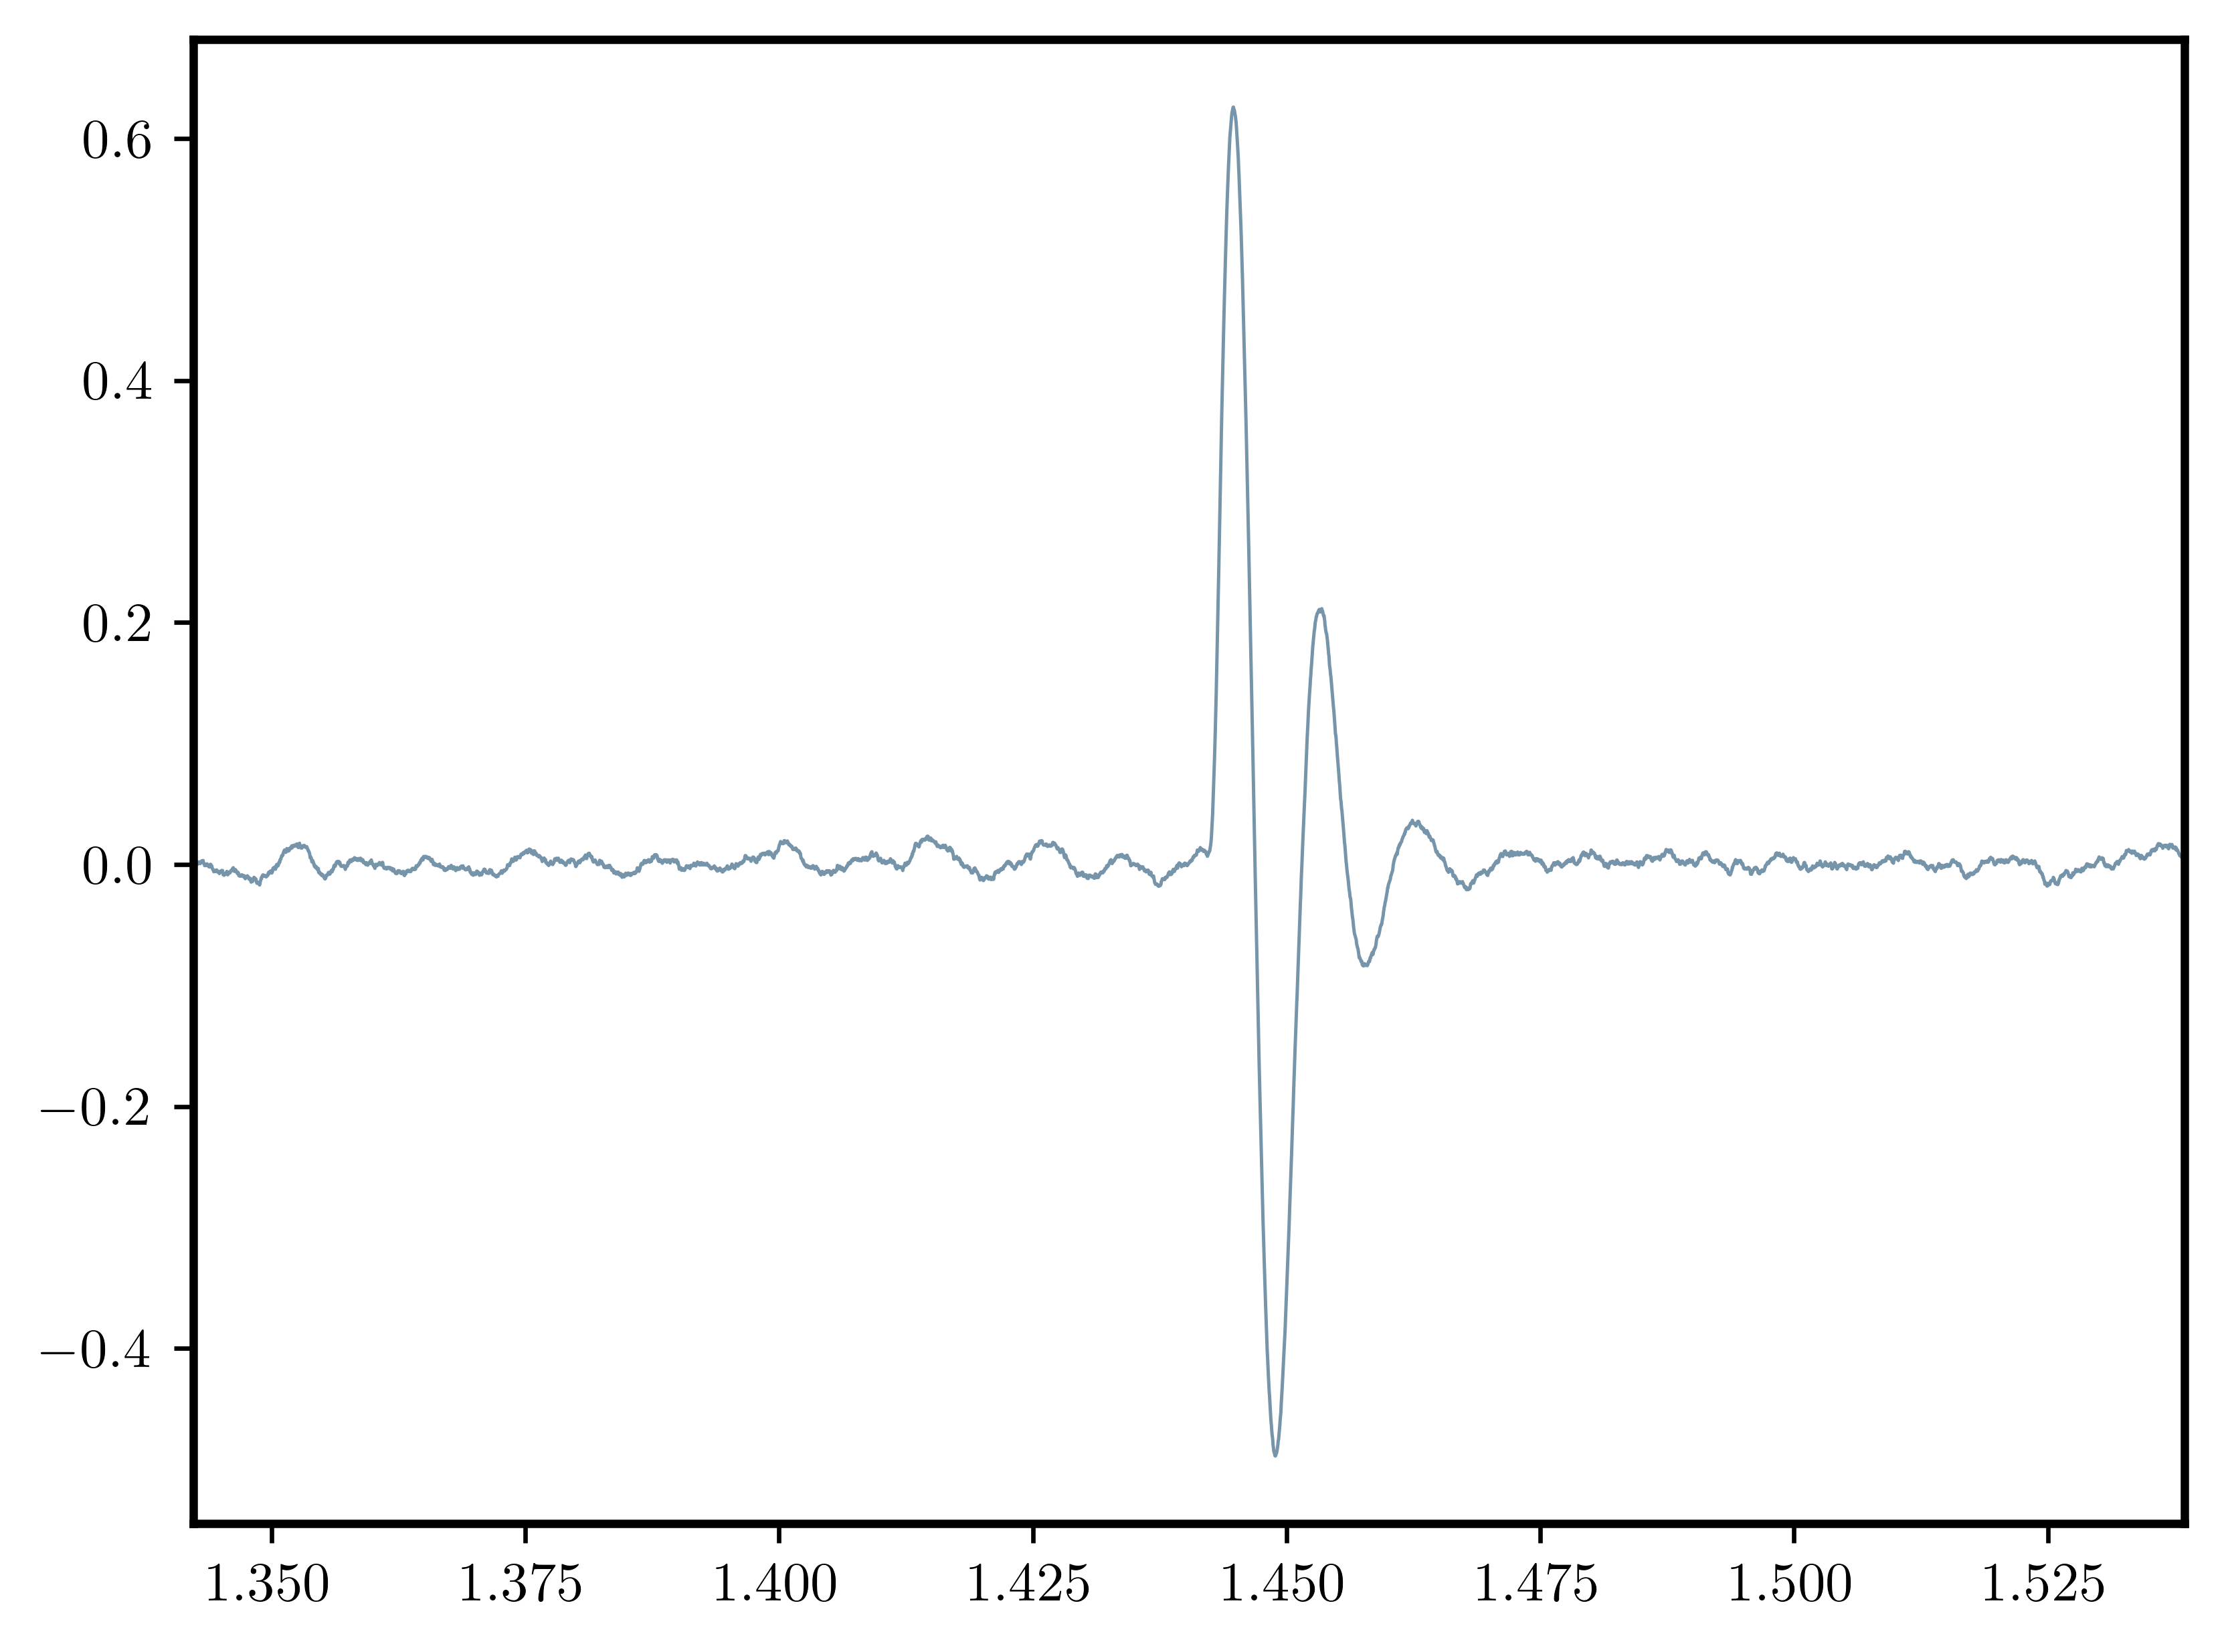

In [126]:
plt.figure()
plt.plot(1e3*t[::control_step],
             estimated_states[:,2][::control_step]*zp_x/1e-9,
             color = C[2], alpha = 0.6, linewidth = 0.6)
plt.xlim([1e3*(t[int(N/2)]) - 0.1, 1e3*(t[int(N/2)] + 10*period)])

In [174]:
m = 4/3*rho*np.pi*radius**3
num = m*omega**2 * (0.6e-9)**2 /2
den = 2000 * hbar/(2*np.pi) * c / wavelength / 1e-6 / env.__kappa__
print(num/den)
dF = g_cs*hbar/env.zp_x
print(2000*dF / (m*omega**2))

2.301825287786532e-08
1.733679416012108e-09


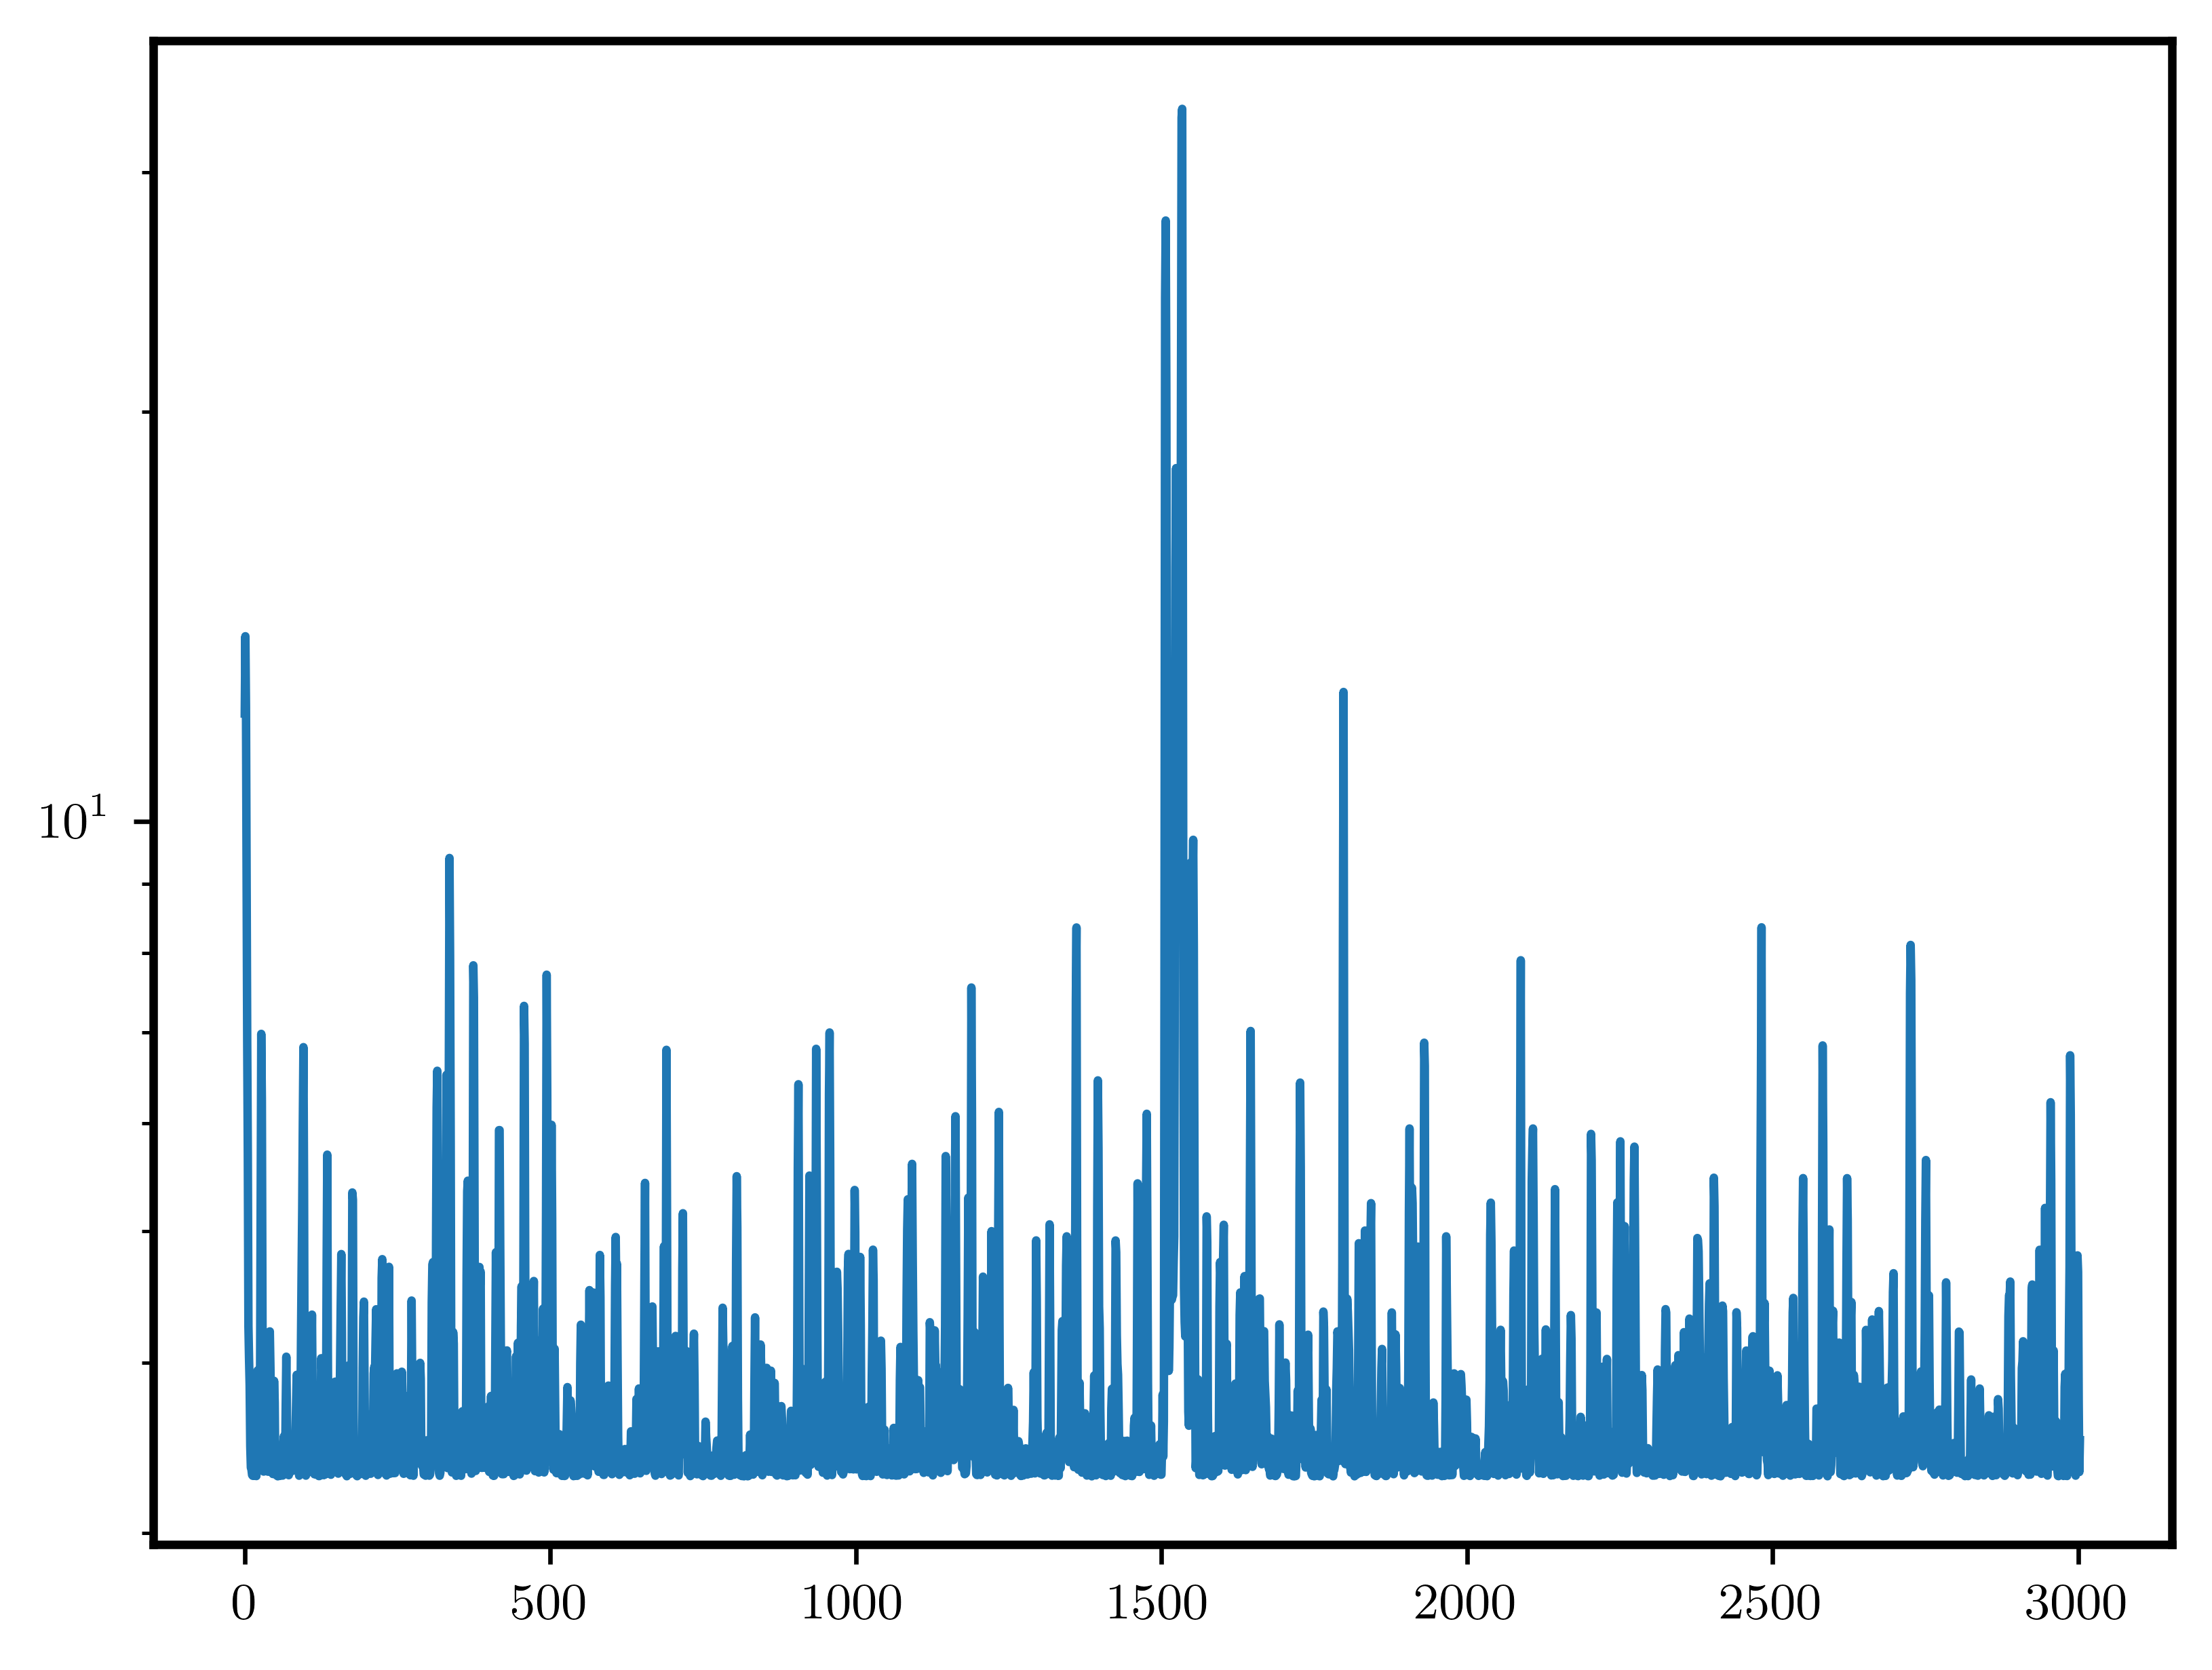

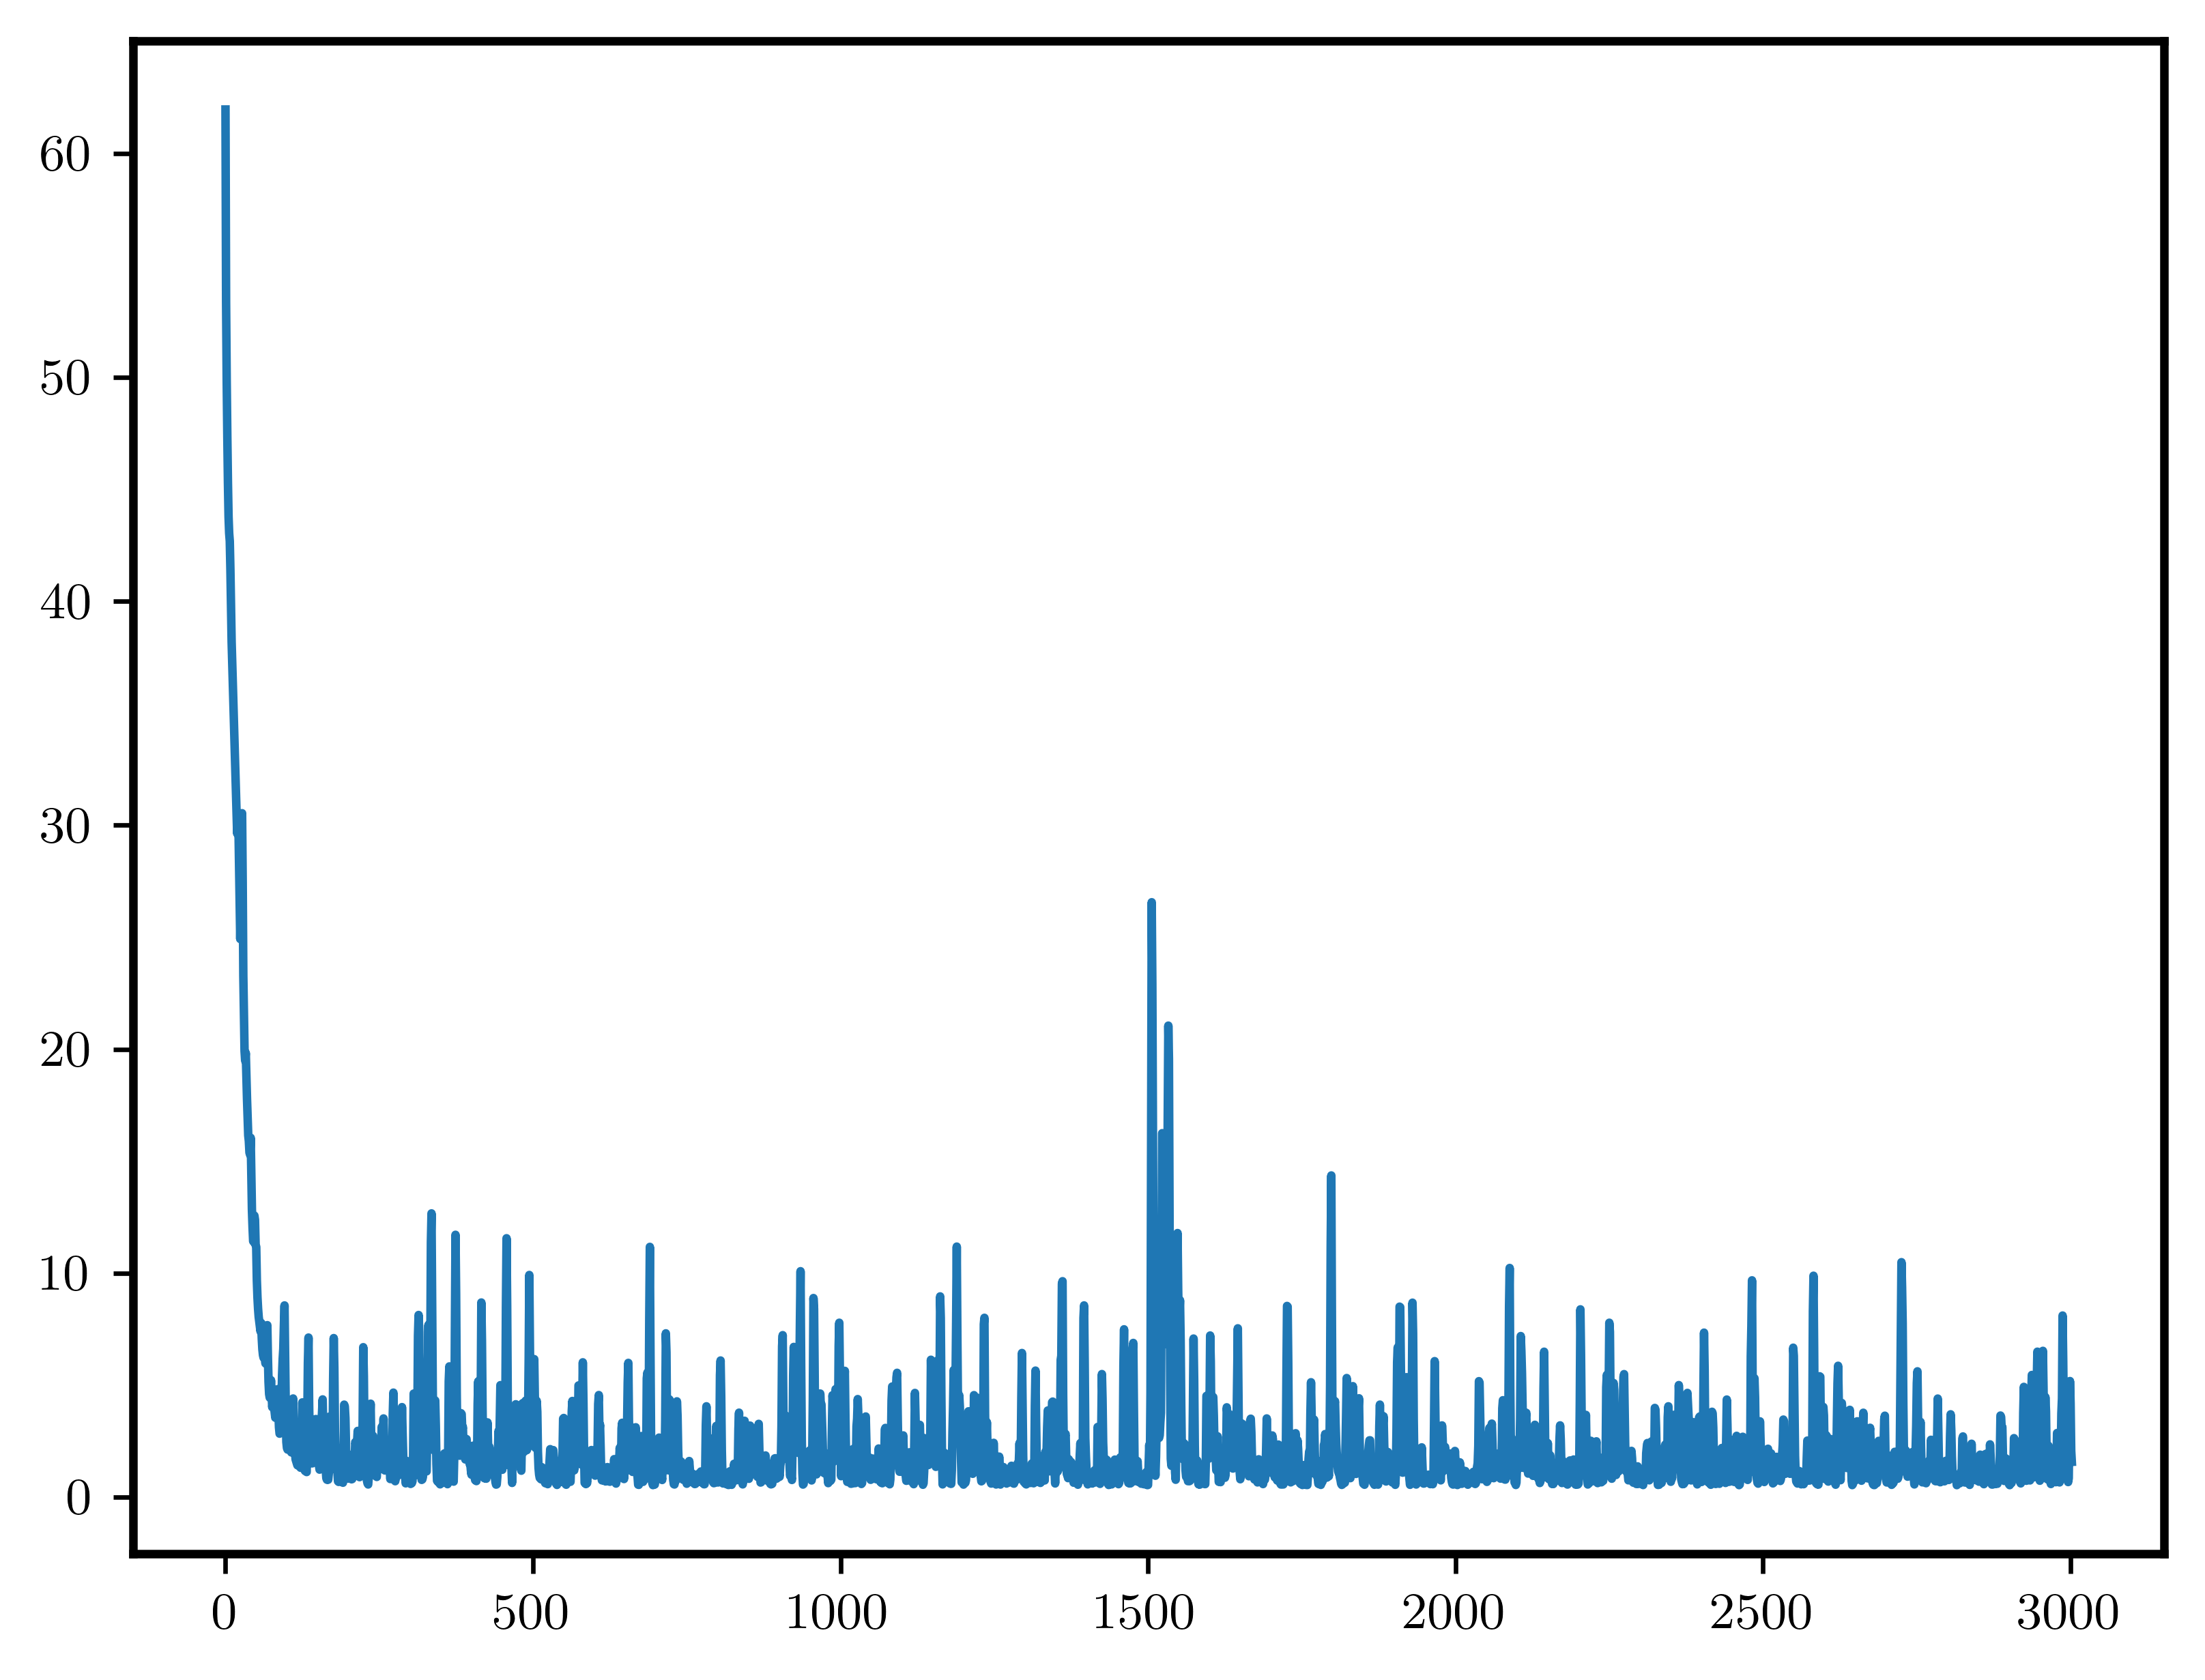

In [203]:
photon_number = 0.5
FSR, f, r, I_factor, optical_input = compute_optical_input(N, delta_t, env, laser_linewidth, photon_number, updated_length, wavelength, duration)
new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
        env.A,
        env.B, 
        optical_input,
        env.thermal_force_std,
        env.backaction_std,
        env.__shot_std__,
        std_detection, 
        eta_detection,
        x0, 
        P0, 
        Ad, 
        Bd, 
        env.C, 
        env.G,
        env.G_lqr,
        Q, 
        R, 
        delta_t, 
        control_step, 
        N
    )
phonons = compute_phonons(estimated_states, cov_aposteriori, control_step, step = step)
fidelity = 1 - compute_fidelity(estimated_states, cov_aposteriori, cov_ss, control_step, step=step)
plt.plot(1/(1-fidelity))
plt.yscale('log')
plt.figure()
plt.plot(phonons)

In [32]:
np.max(SNR_data)

56.07961367070459